# Analysing the undistorted circular grid

In [1]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import skimage
from skimage.feature import blob_dog, blob_doh, blob_log, canny
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.segmentation import slic
from skimage.filters import sobel
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage import measure
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

# Determining the circles centers coordinates

In [2]:
path = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/'
circles = pyfits.getdata(path+'circles_undistorted.fits')


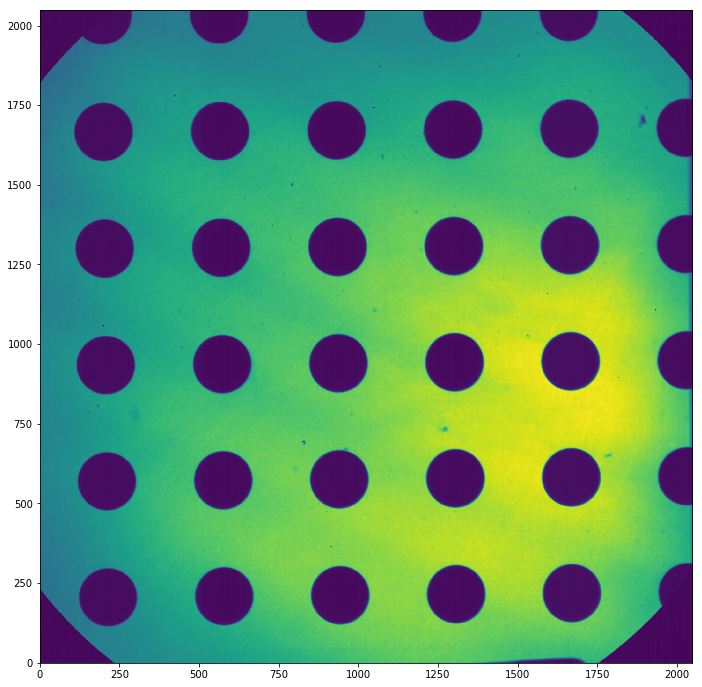

In [3]:
plt.figure(figsize=(18,12))

plt.imshow(circles, origin='lower')


In [4]:
circles = circles/circles.mean()

In [5]:
mask = np.zeros((2048,2048))
for i in range(2048):
    for j in range(2048):
        if circles[i][j] < 0.6:
            mask[i][j] = 1
        else:
            mask[i][j] = 0


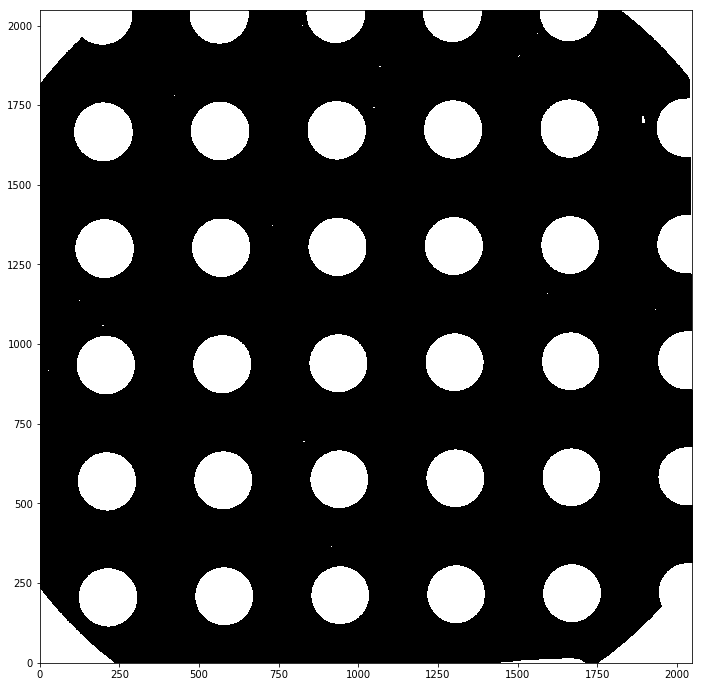

In [6]:
plt.figure(figsize=(18,12))

plt.imshow(mask,cmap='gray', origin='lower')

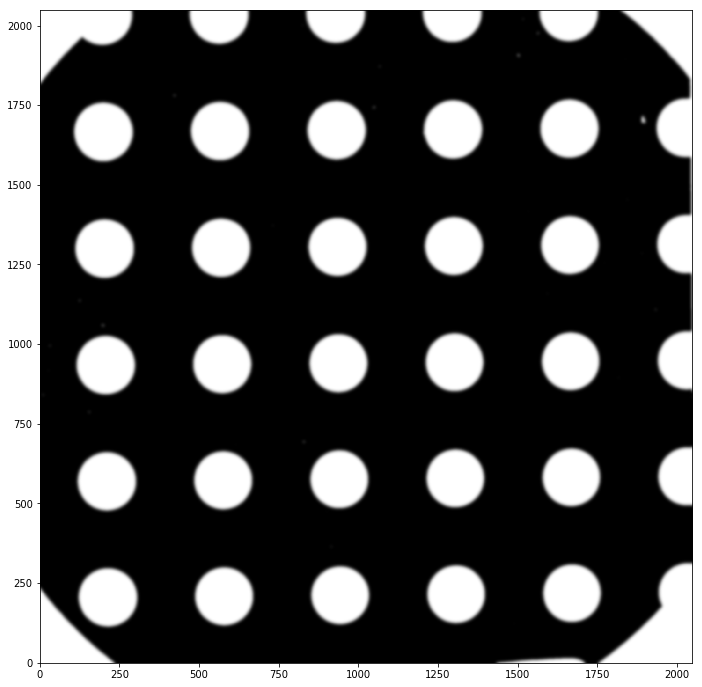

In [7]:

from scipy.ndimage.filters import gaussian_filter as gf
mask_smooth = gf(mask,sigma=5,mode='nearest')
mask_smooth.max()
fig = plt.figure(figsize=(18,12))
plt.imshow(mask_smooth,cmap='gray',origin='lower')
hdu = pyfits.PrimaryHDU(mask_smooth)
#hdu.writeto('mask_smooth_circles.fits')

In [8]:
mask_2 = np.zeros((2048,2048))
for i in range(2048):
         for j in range(2048):
             if mask_smooth[i][j] > 0.6:

                   mask_2[i][j] = 1
             else:
                   mask_2[i][j] = 0

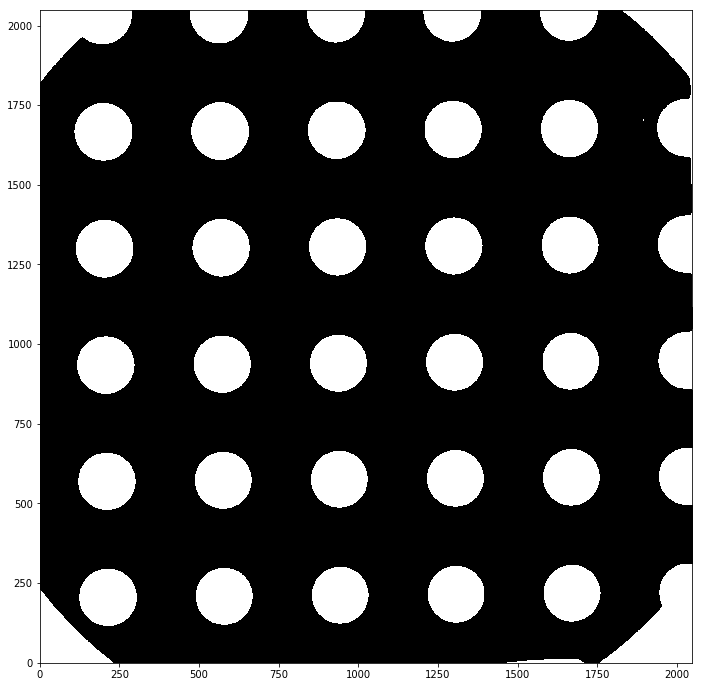

In [9]:
fig = plt.figure(figsize=(18,12))
plt.imshow(mask_2,cmap='gray',origin='lower')
hdu = pyfits.PrimaryHDU(mask_2)
plt.savefig('binary_circles.png',dpi=300)
#hdu.writeto('extended_circles.fits')

# Labeling features using the sequential region labeling in skimage

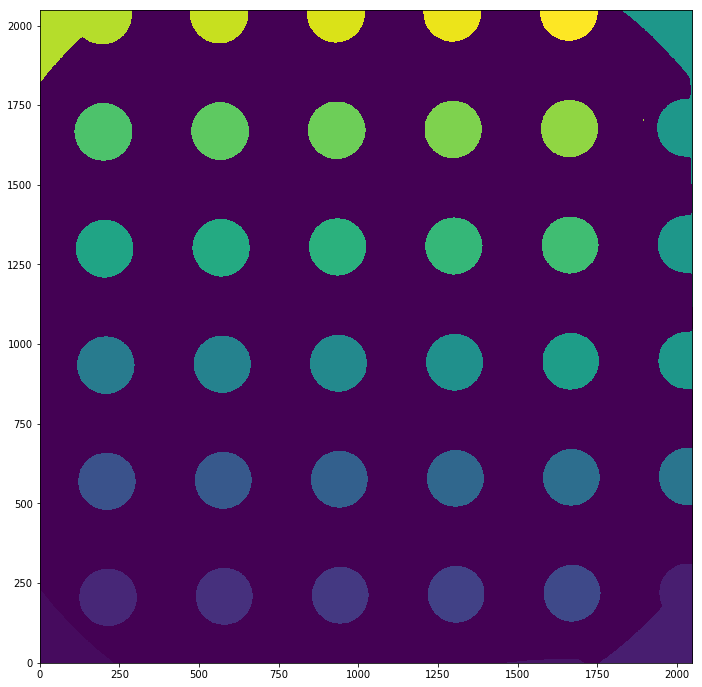

In [35]:
from skimage import measure
from skimage.measure import label
from skimage.measure import regionprops

labels, numb = measure.label(mask_2,background=0, return_num=True)
fig = plt.figure(figsize=(18,12))

plt.imshow(labels, origin='lower')


In [36]:
props = skimage.measure.regionprops(labels)
centers = np.array([prop.centroid for prop in props])
eccen = np.array([prop.eccentricity for prop in props])
R_eq =  np.array([prop.equivalent_diameter for prop in props])
moments_central = np.array([prop.moments for prop in props])
diameter = np.array([prop.equivalent_diameter for prop in props])
area = np.array([prop.area for prop in props])
major =  np.array([prop.major_axis_length for prop in props])
minor = np.array([prop.minor_axis_length for prop in props])
#print major/minor
#print eccen
#print moments_central[0].shape
#print diameter
#print 2*np.sqrt(area/np.pi)

In [13]:
print eccen

[ 0.82929444  0.99845952  0.85067243  0.11040166  0.03738404  0.07302406
  0.07867413  0.11334022  0.07216999  0.04714592  0.06556858  0.07327056
  0.11170162  0.78998956  0.0618779   0.06667463  0.07391393  0.09767336
  0.99513446  0.11690998  0.06585224  0.08288288  0.06879376  0.08544825
  0.10792964  0.05956355  0.10453619  0.06445999  0.09162326  0.08050495
  0.7283465   0.8803558   0.80514422  0.81498473  0.82355292  0.83093985]


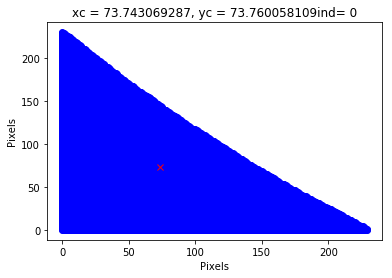

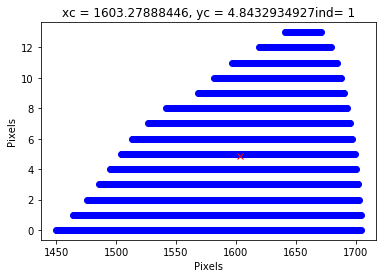

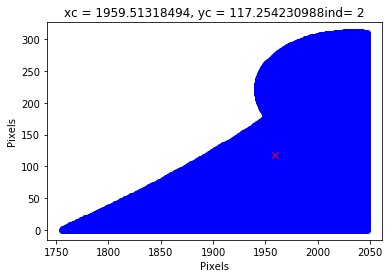

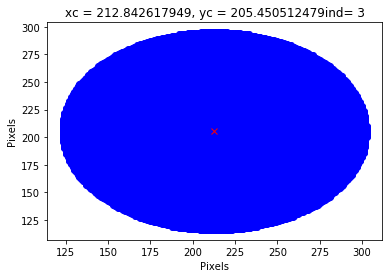

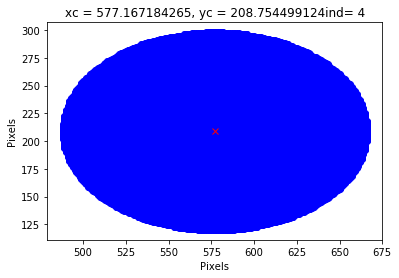

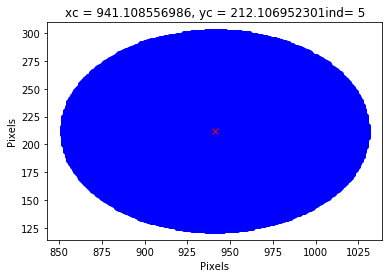

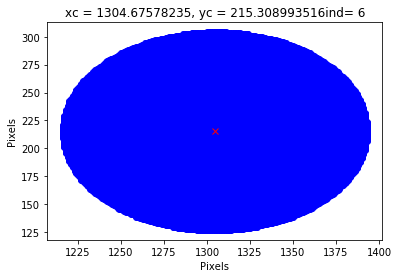

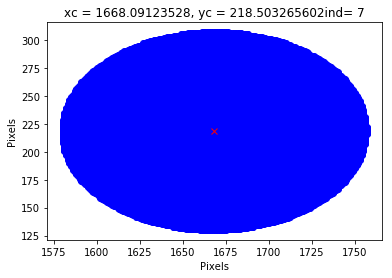

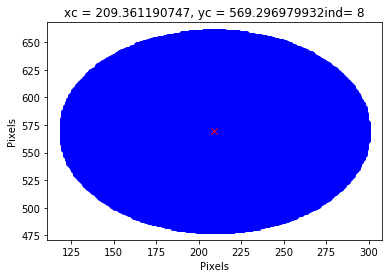

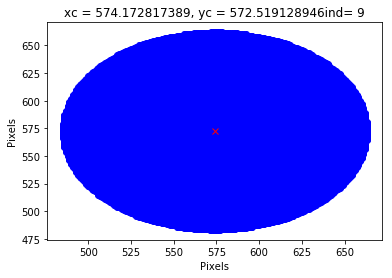

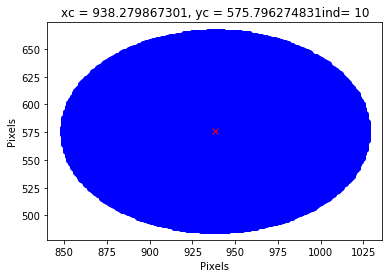

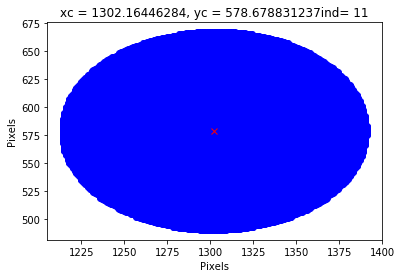

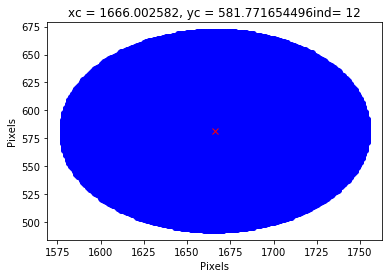

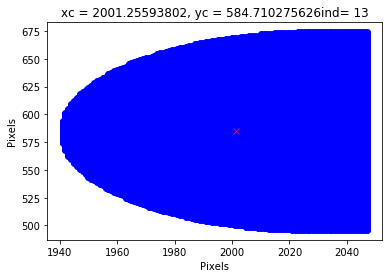

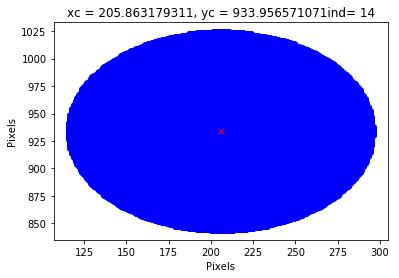

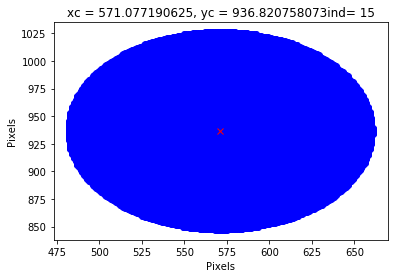

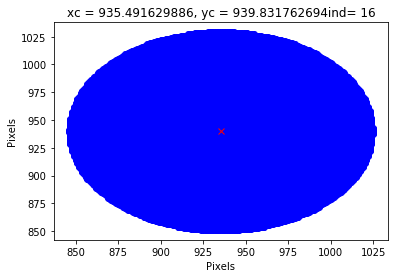

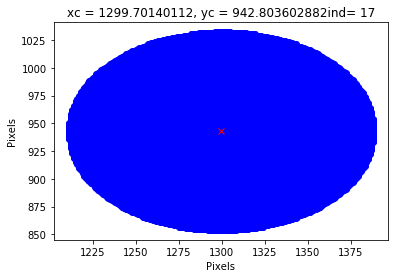

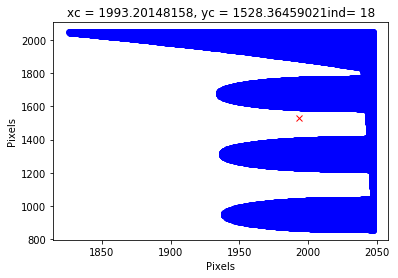

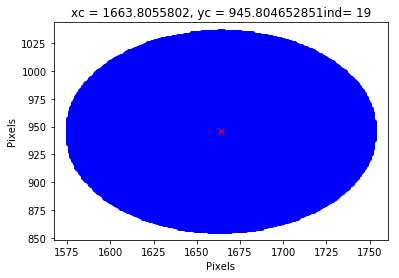

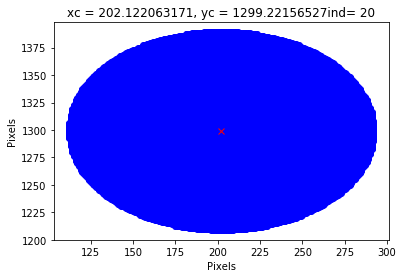

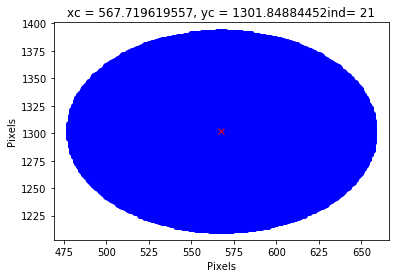

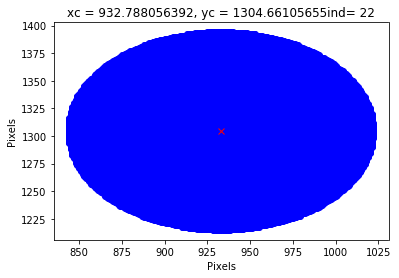

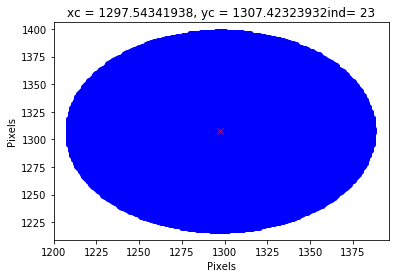

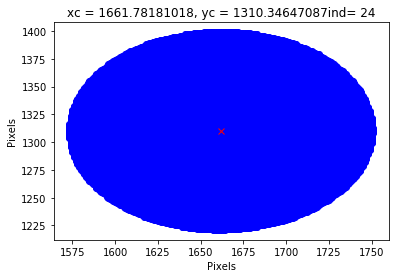

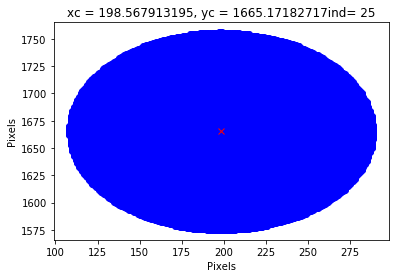

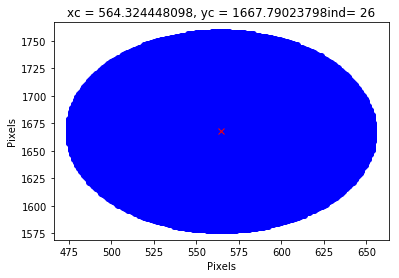

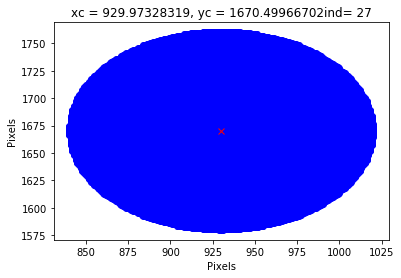

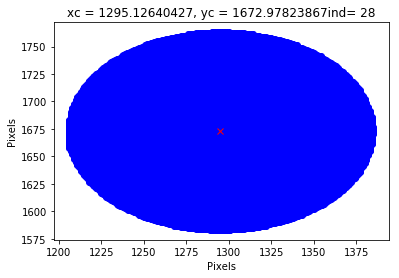

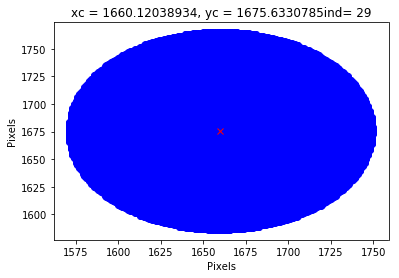

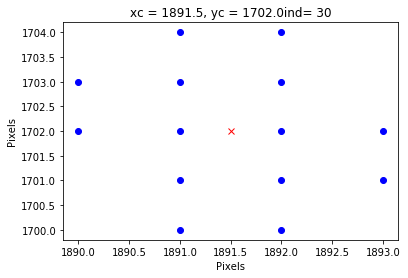

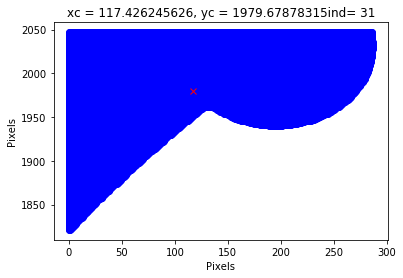

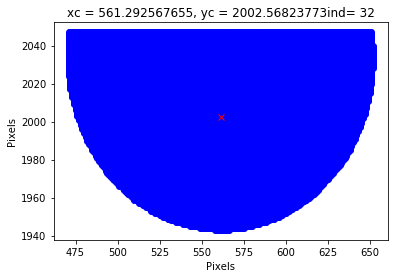

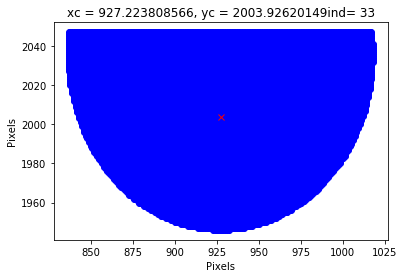

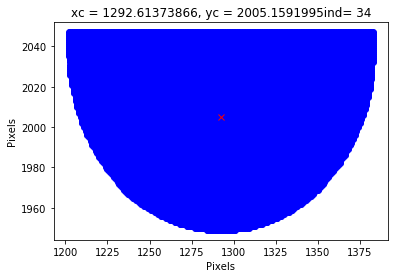

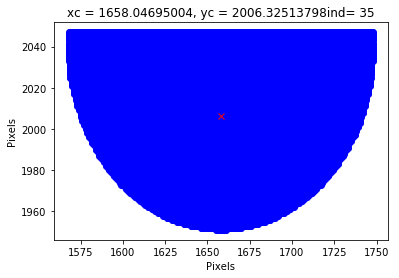

In [20]:
for i in np.arange(numb):
    y, x = props[i].coords[:,0], props[i].coords[:,1]
    yc, xc = props[i].centroid
    plt.plot(x,y,'bo')
    plt.plot(xc,yc,'rx')
    #plt.title('Feature# '+str(label),fontsize=22)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    plt.title('xc = '+str(xc)+', yc = '+str(yc)+'ind= '+str(i))
    plt.show()
#plt.show()

In [37]:
Ind = [0,1,2,13,18,30,31,32,33,34,35]
props = np.delete(props,[Ind])
print [Ind]

[[0, 1, 2, 13, 18, 30, 31, 32, 33, 34, 35]]


In [82]:
centers = np.array([prop.centroid for prop in props])
eccen = np.array([prop.eccentricity for prop in props])


In [46]:
X = centers[:,1]
Y = centers[:,0]
len(Y)

25

In [68]:
'''
F = open('Centers_python_circles_undistorted','w')
for i in range(25):
    F.write(str(centers[i][1]) + ' '+ str(centers[i][0])+'\n')
F.close()
'''

In [69]:
# the distorted coordinates
f = np.loadtxt('/home/fatima/Desktop/solar_orbiter_project/codes/dont_touch/centers_python_lines_circles')

In [70]:
X_d = f[:,0] 
Y_d = f[:,1] 

In [ ]:
k = 7.99207263147e-09; x_d = 1009; y_d = 911
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))


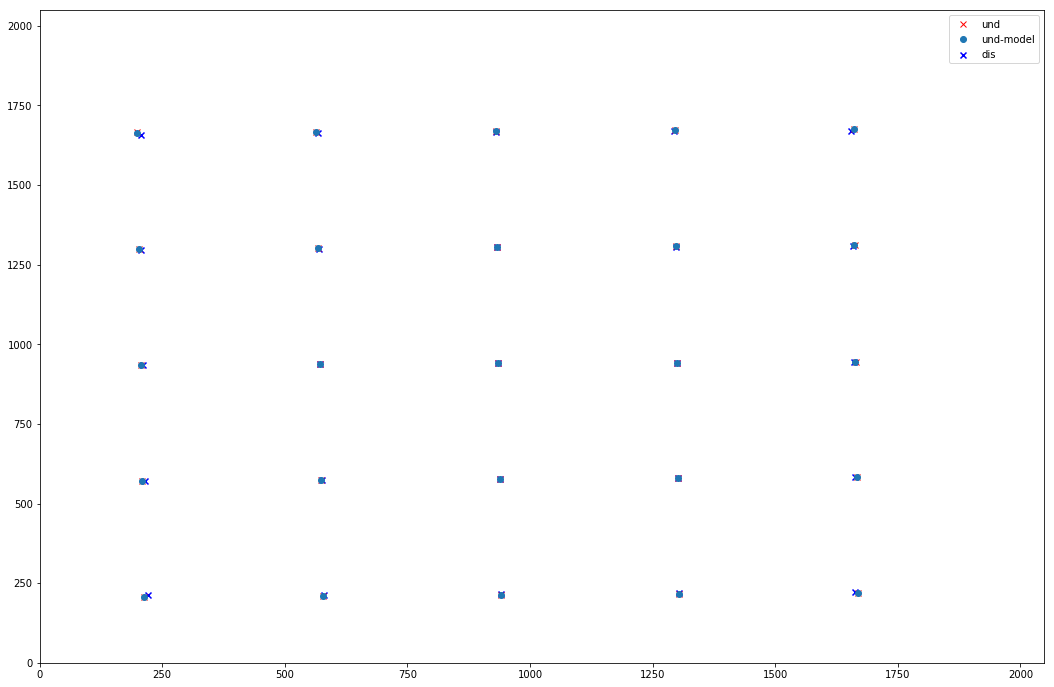

In [80]:
fig = plt.figure(figsize=(18,12))

plt.scatter(x,y,marker='x',color='b',label='dis')
plt.plot(X,Y,'rx',label='und')
plt.plot(X_u,Y_u,'o',label='und-model')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.legend()


In [83]:
R = np.sqrt((X-x_d)**2+(Y-y_d)**2)

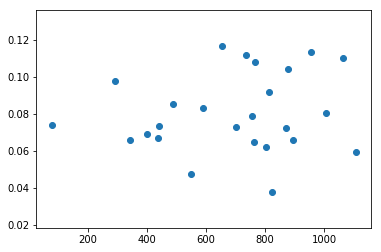

In [85]:
plt.scatter(R,eccen)

In [47]:
Xp = np.reshape(X,(5,5))
Yp = np.reshape(Y,(5,5))


In [81]:
print np.sum((X_u-X)**2)/np.sum(X**2)

2.90255132112e-08


In [49]:
def parabola_lines(x,a,b,c):
    y = a*x**2 + b*x + c
    return y
def parabola_columns(y,m,n,p):
    x = m*y**2 + n*y + p
    return x


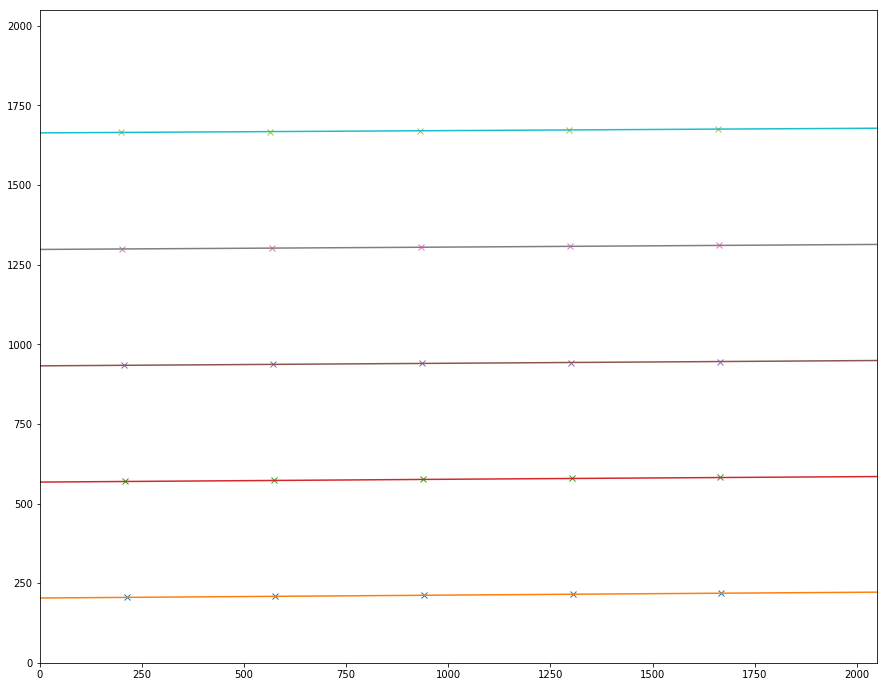

In [64]:
fig=plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
NN = 5
A = np.zeros(NN)
B = np.zeros(NN)
C = np.zeros(NN)
n=0
for m in range(NN):
    x = Xp[m,:]; y = Yp[m,:]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)   ## estimating the guess array for each line
    popt, pcov = curve_fit(parabola_lines, x,y,p0)
     ## GOODNESS OF FIT
    chi_sq_w_lines = np.sum((parabola_lines(x,*popt)-y)**2)
    red_chi_sq_lines = chi_sq_w_lines/(len(x)-len(popt))
    #print chi_sq_w_lines, red_chi_sq_lines
    A[n] = popt[0]; B[n] = popt[1]; C[n] = popt[2]
    xnew = np.linspace(0, 2048, 1000)
    ynew = parabola_lines(xnew, *popt)
    ax.plot(x,y,'x')
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(0,2048)
    ax.set_ylim(0,2048)
    n=n+1
    

#plt.legend()
plt.show()

0.0103262872267 0.00516314361334
0.00259301185432 0.00129650592716
0.00299276506399 0.001496382532
0.0189486080271 0.00947430401354
0.0221036584688 0.0110518292344


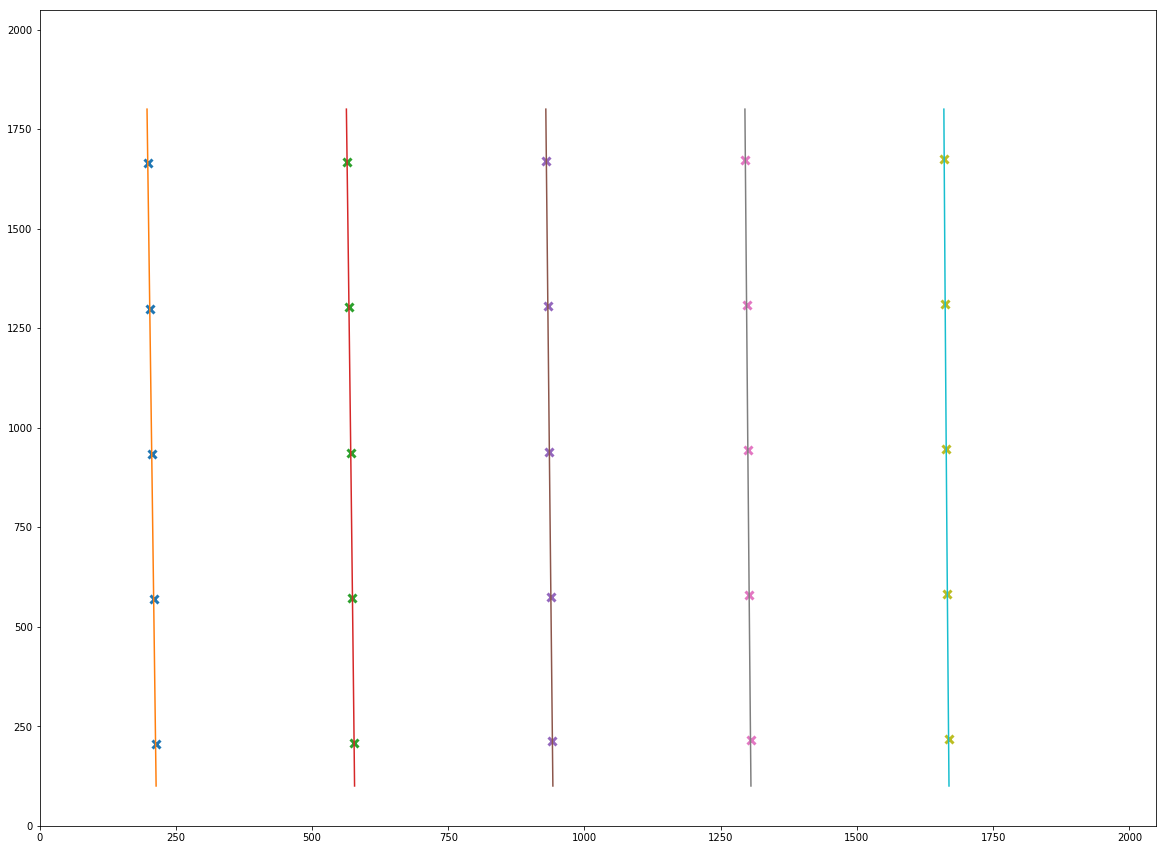

In [65]:
plt.clf()
fig=plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
n=0
NN=5
M = np.zeros(NN)
N =  np.zeros(NN)
P =  np.zeros(NN)

for m in range(len(N)):
    x = Xp[:,m]; y = Yp[:,m]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_columns, y,x,p0)
    chi_sq_w_cols = np.sum((parabola_columns(y,*popt)-x)**2)
    red_chi_sq_cols = chi_sq_w_cols/(len(x)-len(popt))
    print chi_sq_w_cols ,red_chi_sq_cols

    
    M[n]=popt[0]; N[n] = popt[1]; P[n] = popt[2]
    ynew = np.linspace(100, 1800, 100)
    xnew = parabola_columns(ynew, *popt)
    ax.plot(x,y,'x',markersize=8,mew=3)
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(0,2048)
    ax.set_ylim(0,2048)
    n = n+1
#plt.legend()
plt.show()